In [1]:
import imageio
import matplotlib.pyplot as plt
import numpy
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import tensorflow as tf
from tensorflow.python.keras.layers import Conv2D
from utils import show_images, gaussian_filter, image_normalization, rescale

## Dataset

The dataset that we are going to use to train and test this algorithm is [TID2013](http://www.ponomarenko.info/tid2013.htm).
It is comprised of 25 reference images, and 24 different distortions with 5 severy levels each.

In [2]:
def get_image_url(image_idx: int, distortion: int, severity: int) -> str:
    if severity == 0:
        image_type = 'reference_images'
        image_path = f'i{image_idx:02}.bmp'
    else:
        image_type = 'distorted_images'
        image_path = f'i{image_idx:02}_{distortion:02}_{severity}.bmp'
        
    return f'https://data.ocampor.ai/image-quality/tid2013/{image_type}/{image_path}'

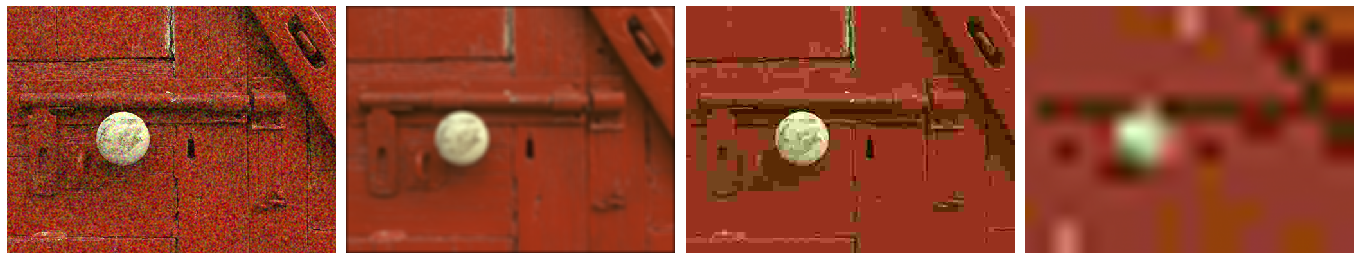

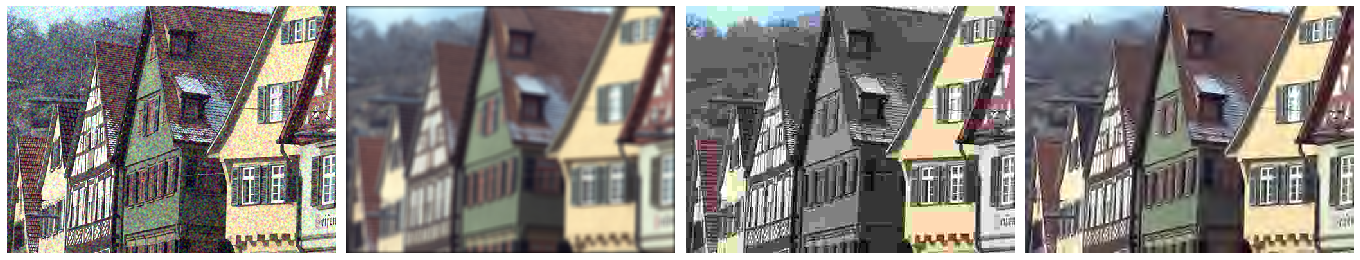

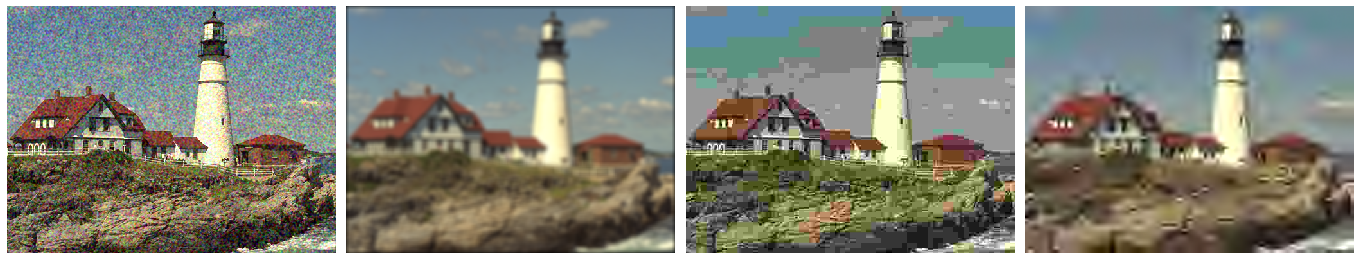

In [3]:
for idx in (2, 8, 21):
    images = []
    for distortion in (3, 8, 10, 11):
        images.append(imageio.imread(get_image_url(idx, distortion, 5)))
    show_images(images)

## Image Normalization

As pre-processing the image is turned into grayscale. As a second calculation, a low pass filter is applied
to the grayscale image. Finally, the low-pass filtered image is subtracted from the grayscale image. The
low frequency image is the result of blurring the image, downscaling by a factor of 1 / 4 and upscaling back
to the original size. 

\begin{align*}
\hat{I} = I_{gray} - I^{low}
\end{align*}

The main reasons for the image normalization are:
1. The Human Visual System (HVS) is not sensitive to changes in low frequency band.
2. Image distortions barely affect the low-frequency component of images. 

In [4]:
@tf.function
def image_preprocess(image: tf.Tensor) -> tf.Tensor:
    assert isinstance(image, tf.Tensor), 'The input must be a tf.Tensor'
    image = tf.cast(image, tf.float32)
    image = tf.image.rgb_to_grayscale(image)
    image_low = gaussian_filter(image, 16, 7 / 6)
    image_low = rescale(image_low, 1 / 4, method=tf.image.ResizeMethod.BICUBIC)
    image_low = rescale(image_low, 4, method=tf.image.ResizeMethod.BICUBIC)
    return image - tf.cast(image_low, image.dtype)

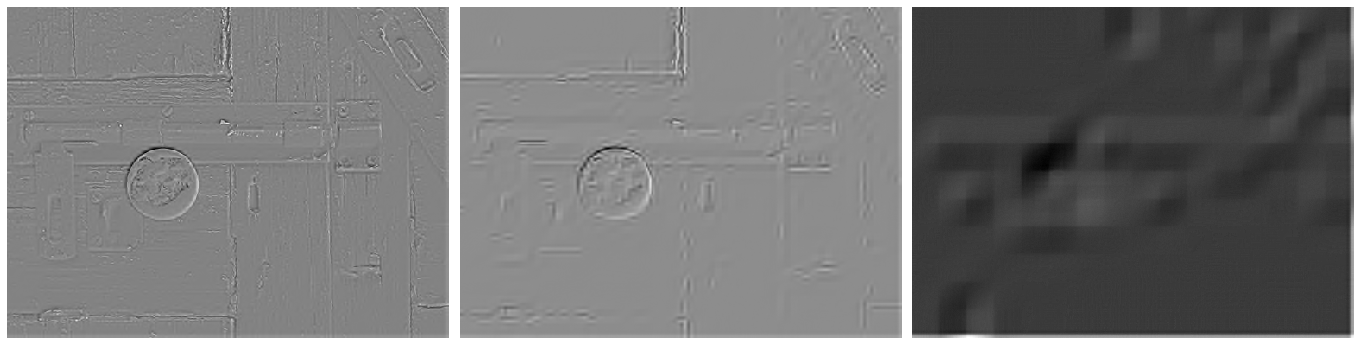

In [5]:
results = []
for severity in (1, 3, 5):
    I = tf.convert_to_tensor(imageio.imread(get_image_url(2, 11, severity)))
    I_d = image_preprocess(I)
    I_d = tf.image.grayscale_to_rgb(I_d)
    results.append(image_normalization(I_d, 0, 1))

show_images(results)

## Objective Error Map

In the first stage of training, the objective error maps are used as proxy regression targets to get the effect of 
increasing data. The loss function is defined by the mean squared error between the predicted and ground-truth error
maps.

\begin{align*}
\mathbf{e}_{gt} = err(\hat{I}_r, \hat{I}_d)
\end{align*}

and $err(\cdot)$ is any error function. The authors decided to use

\begin{align*}
\mathbf{e}_{gt} = | \hat{I}_r -  \hat{I}_d | ^ p
\end{align*}

with $p=0.2$ in order to prevent that the values in the error map are small or close to zero.

In [6]:
@tf.function
def error_map(reference: tf.Tensor, distorted: tf.Tensor, p: float=0.2) -> tf.Tensor:
    assert reference.shape == distorted.shape, 'Both images must be of the same size'
    assert reference.dtype == tf.float32 and distorted.dtype == tf.float32, 'dtype must be tf.float32'
    return tf.pow(tf.abs(reference - distorted), p)

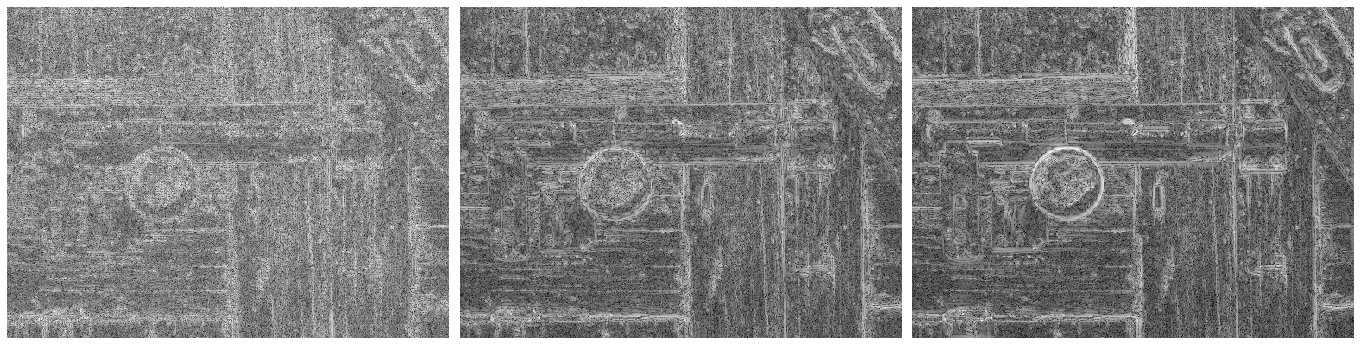

In [7]:
I = tf.convert_to_tensor(imageio.imread(get_image_url(2, 11, 0)))
I_r = image_preprocess(I)
results = []
for severity in (1, 3, 5):
    I = tf.convert_to_tensor(imageio.imread(get_image_url(2, 11, severity)))
    I_d = image_preprocess(I)
    e_gt = error_map(I_r, I_d, 0.2)
    e_gt = tf.image.grayscale_to_rgb(e_gt)
    e_gt = image_normalization(e_gt, 0, 1)
    results.append(e_gt)

show_images(results, cmap='gray')

## Reliability Map Prediction

According to the author, the model is likely to fail to predict the objective error map of
homogeneous regions without having information of its pristine image. Thus, he proposes a 
reliability function. The assumption is that blurry regions have lower reliability than textured 
regions.

\begin{align*}
\mathbf{r} = \frac{2}{1 + exp(-\alpha|\hat{I}_d|)} - 1
\end{align*}

where α controls the saturation property of the reliability map. To assign sufficiently
large values to pixels with small values, the positive part of a sigmoid is used.

In [8]:
@tf.function
def reliability_map(distorted: tf.Tensor, alpha: float) -> tf.Tensor:
    assert distorted.dtype == tf.float32, 'The Tensor must by of dtype tf.float32'
    return 2 / (1 + tf.exp(- alpha * tf.abs(distorted))) - 1

Besides, to prevent the reliability map to directly affect the predicted score,
it is divided by its average

\begin{align*}
\mathbf{\hat{r}} = \frac{1}{\frac{1}{H_rW_r}\sum_{(i,j)}\mathbf{r}(i,j)}\mathbf{r}
\end{align*}

In [9]:
@tf.function
def average_reliability_map(distorted: tf.Tensor, alpha: float) -> tf.Tensor:
    r = reliability_map(distorted, alpha)
    return r / tf.reduce_mean(r)

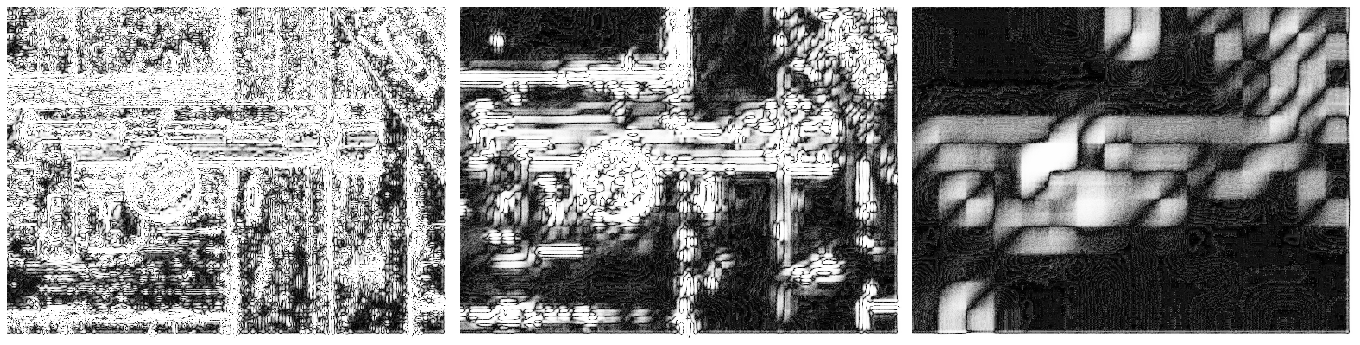

In [10]:
results = []
for severity in (1, 3, 5):
    I = tf.convert_to_tensor(imageio.imread(get_image_url(2, 11, severity)))
    I_d = image_preprocess(I)
    r = average_reliability_map(I_d, 1)
    r = tf.image.grayscale_to_rgb(r)
    results.append(image_normalization(r, 0, 1))

show_images(results, cmap='gray')

## Loss function
The loss function is the mean square error of the product between the reliability map and the
error. The error is the difference between the predicted error map and the ground-truth error map.

\begin{align*}
\mathcal{L}_1(\hat{I}_d; \theta_f, \theta_g) = ||g(f(\hat{I}_d, \theta_f), \theta_g) - \mathbf{e}_{gt}) \odot \mathbf{\hat{r}}||^2_2
\end{align*}

In [ ]:
def diqa_loss_1(distorted):
    def loss(y_true, y_pred):
        return (y_pred - y_true) * average_reliability_map(distorted)
    return loss

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32').reshape(60000, 28, 28, 1) / 255
x_test = x_test.astype('float32').reshape(10000, 28, 28, 1) / 255
y_train = tf.image.resize(x_train, [7, 7])

In [ ]:
input = tf.keras.Input(shape=(None, None, 1), batch_size=1, name='original_image')
f = Conv2D(48, (3, 3), name='Conv1', activation='relu', padding='same')(input)
f = Conv2D(48, (3, 3), name='Conv2', activation='relu', padding='same', strides=(2, 2))(f)
f = Conv2D(64, (3, 3), name='Conv3', activation='relu', padding='same')(f)
f = Conv2D(64, (3, 3), name='Conv4', activation='relu', padding='same', strides=(2, 2))(f)
f = Conv2D(64, (3, 3), name='Conv5', activation='relu', padding='same')(f)
f = Conv2D(64, (3, 3), name='Conv6', activation='relu', padding='same')(f)
f = Conv2D(128, (3, 3), name='Conv7', activation='relu', padding='same')(f)
f = Conv2D(128, (3, 3), name='Conv8', activation='relu', padding='same')(f)
g = Conv2D(1, (1, 1), name='Conv9', padding='same', activation='linear')(f)
objective_error_map = tf.keras.Model(input, g, name='objective_error_map')

In [ ]:
optimizer = tf.optimizers.Nadam(learning_rate=2 * 10 ** -4)
objective_error_map.compile(
    optimizer=optimizer,
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.MeanSquaredError()])

In [ ]:
objective_error_map.summary()

In [ ]:
history = objective_error_map.fit(x_train, y_train,
                    batch_size=1,
                    epochs=1,
                    validation_split=0.2)

In [ ]:
plt.imshow(x_test[10:11].reshape([28, 28]))
plt.show()

In [ ]:
x = objective_error_map.predict(x_test[10:11])
plt.imshow(x.reshape([7, 7]))
plt.show()